In [67]:
import gymnasium as gym
from gymnasium.envs.registration import register
from gymnasium import error, spaces, utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sys
import yfinance as yf

class TradingEnv(gym.Env):
    def __init__(self, start_date, end_date, tc=0.05/100, ticker='GC=F'):
        self.start = start_date
        self.end = end_date
        self.tc = tc
        self.ticker = ticker

        self.action_space = spaces.Discrete(1)
        self.observation_space = spaces.Box(low=-1,high=1,dtype=np.float32)
        returns = self.load_dataset()
        self.data_df = self.create_features(returns)
        self.curr_index = 0
        self.data_len = self.data_df.shape[0]
        self.action = 0

    def step(self, action):

        done = False
        stock_return = self.extract_return(self.data_df, self.curr_index)
        change_in_position = np.abs(self.action - action)
        cost = change_in_position * self.tc
        reward = action*stock_return - cost

        if self.curr_index == self.data_len - 2:
            done = True
        self.curr_index += 1
        self.action = action

        obs = self.extract_state(self.data_df, self.curr_index).values

        info = { 'date' : self.data_df.index[self.curr_index], 'return' : stock_return }

        return obs, reward, done, info

    def reset(self):
        self.curr_index = 0
        return self.extract_state(self.data_df, self.curr_index).values

    def render(self,mode='human'):
        pass

    def extract_return(self, df, i):
        return df.iloc[i]['Y']

    def extract_state(self, df, i):
        return df.iloc[i][['r%d' % i for i in range(30)]]
    
    def downloader(self):
        history = yf.download(tickers = self.ticker,  # list of tickers
                        period = "5y",         # time period
                        interval = "1d",       # trading interval
                        prepost = False,       # download pre/post market hours data?
                        repair = True)
        return history
    
    def SMA(self, df):
        # 200 SMA
        df['sma200'] = df['Close'].rolling(200).mean()
        # 90 SMA
        df['sma90'] = df['Close'].rolling(90).mean()
        # 30 SMA
        df['sma30'] = df['Close'].rolling(30).mean()

        return df
    
    def MACD(self, df):
        k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
        # Get the 12-day EMA of the closing price
        d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
        # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
        macd = k - d
        # Get the 9-Day EMA of the MACD for the Trigger line
        macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
        # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
        macd_h = macd - macd_s
        # Add all of our new values for the MACD to the dataframe
        df['macd'] = df.index.map(macd)
        df['macd_h'] = df.index.map(macd_h)
        df['macd_s'] = df.index.map(macd_s)

        return df
    
    def RSI(self, df):
        delta = df['Close'].diff()
        up = delta.clip(lower=0)
        down = -1*delta.clip(upper=0)
        ema_up = up.ewm(com=13, adjust=False).mean()
        ema_down = down.ewm(com=13, adjust=False).mean()
        rs = ema_up/ema_down
        df['rsi'] = 100 - (100/(1 + rs))

        return df

    def SMA_VOLUME(self, df):
        # 90 SMA
        df['volume90'] = df['Volume'].rolling(90).mean()

        return df

    def load_dataset(self):
        df = self.downloader()
        # apply naming
        #df['ticker'] = self.ticker
        # calculate SMAs
        #self.SMA(df)
        # calculate MACD
        #self.MACD(df)
        # calculate RSI
        #self.RSI(df)
        # calculate SMA_Volume
        #self.SMA_VOLUME(df)
        mask = ( self.start <= df.index ) & ( df.index <= self.end )
        df = df[mask]
        df = df.sort_values(by='Date')
        returns = df['Close'].pct_change()
        
        return returns

    def create_features(self, returns):
        dfs = []
        for i in range(30):
            dfs.append(returns.shift(i).rename('r%d'%i))
        dfs.append(returns.shift(-1).rename('Y'))
        df_net = pd.concat(dfs, axis=1)
        df_net = df_net.dropna()
        
        return df_net

In [77]:
ENV_NAME = 'TradingEnv-v0'

reg = register(
    id=ENV_NAME,
    entry_point='__main__:TradingEnv',
    kwargs={
        'start_date' : '2019-01-01',
        'end_date' : '2023-01-10',
    }
)
env = gym.make(ENV_NAME)
print(env.reset())

/Users/zacharyburpee/miniforge3/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment TradingEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


[*********************100%***********************]  1 of 1 completed
[-7.62892861e-04  1.22219502e-03  1.68320671e-03 -5.10006198e-03
  3.28389085e-03 -7.63463810e-05 -3.57628317e-03 -7.61604295e-05
 -1.97431509e-03 -2.12163890e-03  7.48143108e-03  1.29955153e-03
  4.45326063e-03  3.85386150e-03  1.43069730e-02 -3.11744999e-03
  4.67817221e-04  9.36510674e-04 -7.51351756e-03 -4.64521212e-04
  4.19843307e-03 -2.24965051e-03  1.55388085e-03  1.86815950e-03
 -3.56790311e-03  4.75381693e-03 -2.79771334e-03  3.19645889e-03
 -7.04450945e-03  8.43095147e-03]


/Users/zacharyburpee/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:190: UserWarning: WARN: Future gymnasium versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/zacharyburpee/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:203: UserWarning: WARN: Future gymnasium versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/zacharyburpee/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:211: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


In [78]:
# Build deep Q network 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def model_creator(batch_size):
    model = keras.Sequential()
    model.add(keras.Input(shape=(30)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    # you should later modify this neural network
    model.add(layers.Dense(3, activation='softmax')) # you should have one output for each possible action
    return model

In [79]:
batch_size = 32
# Model used for selecting actions (principal)
model = model_creator(batch_size)
# Then create the target model. This will periodically be copied from the principal network 
model_target = model_creator(batch_size)

model.build((batch_size,30,))
model_target.build((batch_size,30,))

In [80]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
tf.keras.utils.disable_interactive_logging()
gamma = 0.99
# Our Experience Replay memory 
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward_tracker_train = []
reward_returns = []

# Replay memory size
max_memory = 1000 # You can experiment with different sizes.

running_reward = 0
episode_count = 0
timestep_count = 0
actsize = 3

# how often to train your model - this allows you to speed up learning
# by not performing in every iteration learning. See also refernece paper
# you can set this value to other values like 1 as well to learn every time 

update_after_actions = 4

# How often to update the target network
target_update_every = 25
loss_function = keras.losses.MeanSquaredError() # You can use the Huber loss function or the mean squared error function 

max_episodes = 50
max_steps_per_episode = 1000
last_n_reward = 100
decayRate = 0.99
epsilon = 0.2
eps_delta = epsilon / 300

for episode in range(max_episodes):
    state = np.array(env.reset())
    episode_reward = 0
    
    # change epsilon after most states have been explored
    epsilon = np.max((epsilon - eps_delta), 0)

    for timestep in range(1, max_steps_per_episode):
        timestep_count += 1

        # exploration
        if np.random.rand() < epsilon:
            # Take random action
            action = np.random.uniform(-1, 1)
        else:
            # Predict action Q-values
            # From environment state
            state_t = tf.convert_to_tensor(state)
            state_t = tf.expand_dims(state_t, 0)
            action_vals = model.predict(state_t)
            # Choose the best action
            action = np.argmax(action_vals)
            if action == 0:
                action = -1
            elif action == 1:
                action = 0
            else:
                action = 1
            
        # follow selected action
        state_next, reward, done, info = env.step(action);
        state_next = np.array(state_next)
        episode_reward += reward

        # Save action/states and other information in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        rewards_history.append(reward)
        done_history.append(done)

        state = state_next

        # Update every Xth frame to speed up (optional)
        # and if you have sufficient history
        if timestep_count % update_after_actions == 0 and len(action_history) > batch_size:
            
            # Gather slices for correct implementation 
            slices = np.random.choice(len(action_history), batch_size)
            state_sample = np.array(state_history)[slices]
            state_next_sample = np.array(state_next_history)[slices]
            rewards_sample = np.array(rewards_history)[slices]
            action_sample = np.array(action_history)[slices]
            done_sample = np.array(done_history)[slices]

            # Create for the sample states the targets (r+gamma * max Q(...) )
            Q_next_state = model_target.predict(state_next_sample);
            Q_targets = rewards_sample + gamma * np.max(Q_next_state, axis=1)
            
            penalty = 1
            # If the episode was ended (done_sample value is 1)
            # you can penalize the Q value of the target by some value `penalty`
            Q_targets = Q_targets * (1 - done_sample) - penalty*done_sample
            
            # What actions are relevant and need updating
            relevant_actions = tf.one_hot(action_sample, actsize)
            # we will use Gradient tape to do a custom gradient 
            # in the `with` environment we will record a set of operations
            # and then we will take gradients with respect to the trainable parameters
            # in the neural network
            with tf.GradientTape() as tape:
                # Train the model on your action selecting network
                q_values = model(state_sample) 
                # We consider only the relevant actions
                Q_of_actions = tf.reduce_sum(tf.multiply(q_values, relevant_actions), axis=1)
                # Calculate loss between principal network and target network
                loss = loss_function(Q_targets, Q_of_actions)

            # Nudge the weights of the trainable variables towards 
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if timestep_count % target_update_every == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())

        # Don't let the memory grow beyond the limit
        if len(rewards_history) > max_memory:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]
        if done: break
            
    # reward of last 100
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > last_n_reward: del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_tracker_train.append(running_reward)
    episode_count += 1
    template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {}"
    print(template.format(running_reward, episode_count, timestep_count, epsilon))

/Users/zacharyburpee/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:235: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/zacharyburpee/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:157: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/zacharyburpee/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
2023-05-02 16:34:31.195580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-02 16:34:31.723897: I tenso

running reward: -0.44 at episode 1, frame count 983, epsilon 0.19933333333333333
running reward: -0.20 at episode 2, frame count 1966, epsilon 0.19866666666666666
running reward: -0.19 at episode 3, frame count 2949, epsilon 0.19799999999999998
running reward: -0.14 at episode 4, frame count 3932, epsilon 0.1973333333333333
running reward: -0.17 at episode 5, frame count 4915, epsilon 0.19666666666666663
running reward: -0.17 at episode 6, frame count 5898, epsilon 0.19599999999999995
running reward: -0.19 at episode 7, frame count 6881, epsilon 0.19533333333333328
running reward: -0.21 at episode 8, frame count 7864, epsilon 0.1946666666666666
running reward: -0.17 at episode 9, frame count 8847, epsilon 0.19399999999999992
running reward: -0.15 at episode 10, frame count 9830, epsilon 0.19333333333333325
running reward: -0.15 at episode 11, frame count 10813, epsilon 0.19266666666666657
running reward: -0.15 at episode 12, frame count 11796, epsilon 0.1919999999999999
running reward:

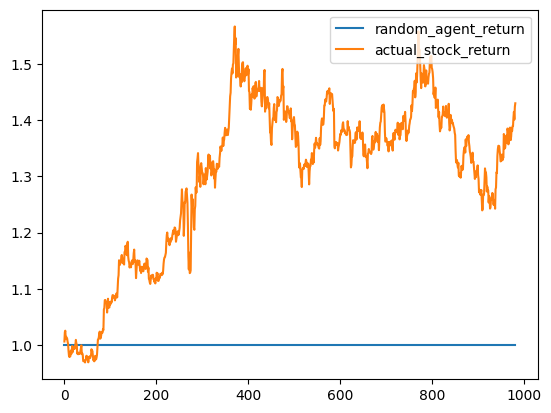

In [82]:
obs = env.reset()
done = False

reward_returns = []
while not done:
    # 0 - hold, -1 - sell, 1 - buy
    state_t = tf.convert_to_tensor(obs)
    state_t = tf.expand_dims(state_t, 0)
    action_vals = model.predict(state_t)
    # Choose the best action
    action = np.argmax(action_vals)
    if action == 0:
        action = -1
    elif action == 1:
        action = 0
    else:
        action = 1
        
    obs, reward, done, info = env.step(action);
    reward_returns.append( (reward,info['return']) )
    

i = list(range(len(reward_returns)))
agent_returns = np.cumprod([ 1 + x[0] for x in reward_returns ])
stock_returns = np.cumprod([ 1 + x[1] for x in reward_returns ])

plt.plot(i, agent_returns, label='random_agent_return')
plt.plot(i, stock_returns, label='actual_stock_return')
plt.legend()
plt.show()